In [61]:
import numpy as np
import matplotlib.pyplot as plt

def generate_instrument_function_multi_peak(jitter_std_dev_ps=50.0,
                                          photon_count=10000,
                                          time_resolution_ps=10.0,
                                          time_range_ns=2.0,
                                          peak_delays_ps=[0.0, 200.0],
                                          peak_ratios=[1.0, 0.5],
                                          peak_widths_ps=[10.0,20],
                                          detector_response_type="gaussian",
                                          detector_response_params=None,
                                          avg_noise_floor=20,
                                          sd_noise_floor=5
                                          ):
    """
    Generates a simulated instrument function for a TCSPC system with multiple discrete peaks,
    accounting for laser pulse width.

    Includes system jitter, detector response, laser pulse width, and multiple peaks.
    Ensures no negative times in the generated time-of-flight distribution.

    Args:
        jitter_std_dev_ps (float): Standard deviation of the system's timing jitter in picoseconds.
        photon_count (int): Total number of simulated photon arrival events (distributed across peaks).
        time_resolution_ps (float): Time resolution of the TCSPC system (bin width) in picoseconds.
        time_range_ns (float): Total time range to simulate in nanoseconds.
        peak_delays_ps (list): List of time delays (in picoseconds) for each peak relative to the first peak (delay 0).
        peak_ratios (list): List of intensity ratios for each peak relative to the first peak (ratio 1).
        detector_response_type (str): Type of detector response function ("gaussian", "none").
        detector_response_params (dict or None): Parameters for detector response (e.g., {'fwhm_ps': float} for "gaussian").
        laser_pulse_width_ps (float): Full Width at Half Maximum (FWHM) of the laser pulse in picoseconds.

    Returns:
        tuple: A tuple containing:
            - time_bins_ps (np.array): Array of time bin edges in picoseconds, starting from 0.
            - instrument_function (np.array): Array representing the counts in each time bin.
    """

    if len(peak_delays_ps) != len(peak_ratios) != len(peak_widths_ps):
        raise ValueError("peak_delays_ps, peak_ratios and peak_widths_ps must have the same length.")

    time_range_ps = time_range_ns * 1000.0
    num_bins = int(time_range_ps / time_resolution_ps)
    time_bins_ps = np.linspace(0.0, time_range_ps, num_bins + 1)
    total_instrument_function = np.zeros(num_bins)

    

    for i in range(len(peak_delays_ps)):
        peak_delay_ps = peak_delays_ps[i]
        peak_ratio = peak_ratios[i]
        peak_width_ps = peak_widths_ps[i]
        
        # Laser pulse width standard deviation
        laser_std_dev_ps = peak_width_ps / (2 * np.sqrt(2 * np.log(2)))
        
        
        peak_photon_count = int(photon_count * peak_ratio / sum(peak_ratios))

        # 1. Simulate arrival times based on Laser Pulse Width
        laser_emission_times_ps = np.random.normal(loc=peak_delay_ps,
                                                    scale=laser_std_dev_ps,
                                                    size=peak_photon_count)

        # 2. Apply System Jitter
        jittered_times_ps = np.random.normal(loc=laser_emission_times_ps,
                                             scale=jitter_std_dev_ps,
                                             size=peak_photon_count)

        simulated_arrival_times_ps = jittered_times_ps.copy() # Start with jittered times

        # 3. Apply Detector Response (Optional)
        if detector_response_type == "gaussian":
            if detector_response_params is None:
                detector_fwhm_ps = jitter_std_dev_ps * 2
            else:
                detector_fwhm_ps = detector_response_params.get('fwhm_ps', jitter_std_dev_ps * 2)
            detector_std_dev_ps = detector_fwhm_ps / (2 * np.sqrt(2 * np.log(2)))
            simulated_arrival_times_ps = np.random.normal(loc=simulated_arrival_times_ps,
                                                             scale=detector_std_dev_ps,
                                                             size=peak_photon_count)

        # Generate histogram for this peak and add it to the total instrument function
        peak_instrument_function, _ = np.histogram(simulated_arrival_times_ps, bins=time_bins_ps)
        total_instrument_function += peak_instrument_function + np.random.normal(avg_noise_floor, sd_noise_floor, num_bins)

    return time_bins_ps, total_instrument_function


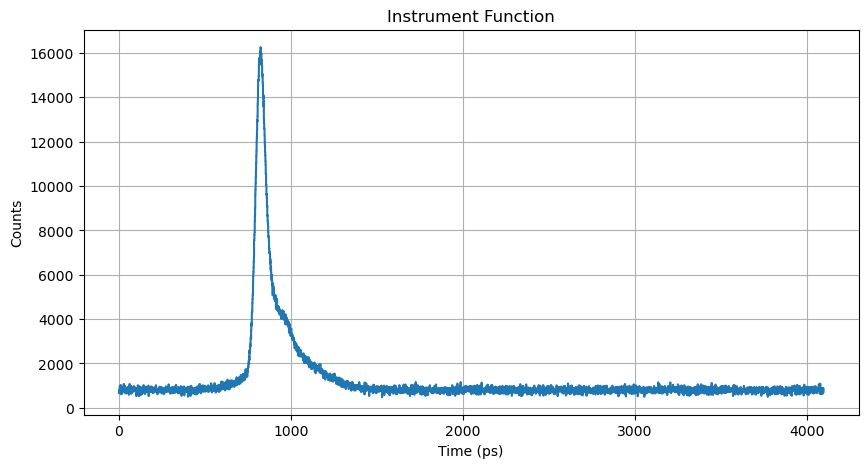

In [72]:
# --- Example Usage with Laser Pulse Width ---

time_bins_combined, instrument_function_combined = generate_instrument_function_multi_peak(
    photon_count=2000000,   
    time_range_ns=25,
    time_resolution_ps=6.1,
    peak_widths_ps=[350.0, 550, 700.0, 2500],
    jitter_std_dev_ps=30.0,
    detector_response_type="gaussian",
    detector_response_params={'fwhm_ps': 40.0},
    peak_delays_ps=[5000, 5200, 5800, 6000],
    peak_ratios=[1.0, 0.6, 0.3, 1],
    avg_noise_floor=200,
    sd_noise_floor=50
)

plt.figure(figsize=(10, 5))
plt.plot(instrument_function_combined, drawstyle='steps-post')
plt.title('Instrument Function')
plt.xlabel('Time (ps)')
plt.ylabel('Counts')
plt.grid(True)
#plt.xlim(time_bins_combined[0], time_bins_combined[-1])
plt.show()
